In [2]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
%matplotlib inline

pyro.set_rng_seed(42)

## Model 1 - Indirect Race Path

### Preprocessing

In [3]:
# race
df = pd.read_csv('model1_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )
print(race_alias)
race_prob

['African-American', 'Caucasian']


tensor([0.5999, 0.4001])

In [4]:
# sex
df = pd.read_csv('model1_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )
print(sex_alias)
sex_prob

['Female', 'Male']


tensor([0.1992, 0.8008])

In [5]:
# age_cat
df = pd.read_csv('model1_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )
print(age_cat_alias)
age_cat_prob

['25 - 45', 'Greater than 45', 'Less than 25']


tensor([0.5701, 0.2182, 0.2117])

In [6]:
# c_charge_degree
df = pd.read_csv('model1_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in c_charge_degree_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

c_charge_degree_probs = torch.tensor( l0 )

print(c_charge_degree_alias)
c_charge_degree_probs

['F', 'M']


tensor([[[[0.6329, 0.3671],
          [0.7273, 0.2727],
          [0.6488, 0.3512]],

         [[0.6787, 0.3213],
          [0.6518, 0.3482],
          [0.7722, 0.2278]]],


        [[[0.5728, 0.4272],
          [0.4795, 0.5205],
          [0.5632, 0.4368]],

         [[0.6294, 0.3706],
          [0.5663, 0.4337],
          [0.6970, 0.3030]]]])

In [7]:
# two_year_recid
df = pd.read_csv('model1_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in c_charge_degree_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

print(two_year_recid_alias)
two_year_recid_probs

[0, 1]


tensor([[0.5010, 0.4990],
        [0.6015, 0.3985]])

In [35]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[race][sex][age_cat]))
    two_year_recid_prob = dist.Categorical(two_year_recid_probs[c_charge_degree])
    two_year_recid = pyro.sample("two_year_recid", two_year_recid_prob)
    return two_year_recid


### Intervention

In [9]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

(array([ 4.,  5., 11., 20., 14., 19., 10.,  6.,  6.,  5.]),
 array([-0.21 , -0.166, -0.122, -0.078, -0.034,  0.01 ,  0.054,  0.098,
         0.142,  0.186,  0.23 ]),
 <BarContainer object of 10 artists>)

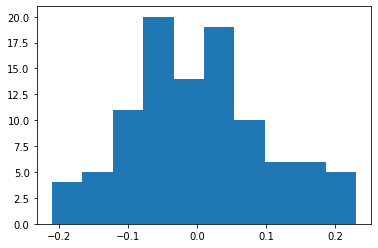

In [11]:
ls = []
for run in range(100):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]
plt.hist(ls) 

### Counterfactual fairness

In [10]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

#### Natural Direct Effects

In [37]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'race': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(0)})() for _ in range(1000)]

In [39]:
e1_avg = sum(e1_samples) / len(e1_samples)
e2_avg = sum(e2_samples) / len(e2_samples)

In [40]:
e1_avg - e2_avg

tensor(-0.1160)

#### Inference

(array([ 3.,  4., 10., 17., 14., 25., 15.,  7.,  3.,  2.]),
 array([0.33 , 0.356, 0.382, 0.408, 0.434, 0.46 , 0.486, 0.512, 0.538,
        0.564, 0.59 ]),
 <a list of 10 Patch objects>)

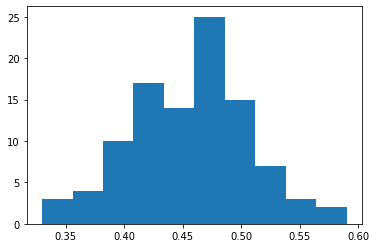

In [11]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in range(100):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]
plt.hist(ls) 

## Model 2 - Direct Race Path

### Preprocessing

In [45]:
# race
df = pd.read_csv('model2_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )
print(race_alias)
race_prob

['African-American', 'Caucasian']


tensor([0.5999, 0.4001])

In [46]:
# sex
df = pd.read_csv('model2_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )
print(sex_alias)
sex_prob

['Female', 'Male']


tensor([0.1992, 0.8008])

In [47]:
# age_cat
df = pd.read_csv('model2_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )
print(age_cat_alias)
age_cat_prob

['25 - 45', 'Greater than 45', 'Less than 25']


tensor([0.5701, 0.2182, 0.2117])

In [48]:
# c_charge_degree
df = pd.read_csv('model2_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in c_charge_degree_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

c_charge_degree_probs = torch.tensor( l0 )

print(c_charge_degree_alias)
c_charge_degree_probs

['F', 'M']


tensor([[[[0.6329, 0.3671],
          [0.7273, 0.2727],
          [0.6488, 0.3512]],

         [[0.6787, 0.3213],
          [0.6518, 0.3482],
          [0.7722, 0.2278]]],


        [[[0.5728, 0.4272],
          [0.4795, 0.5205],
          [0.5632, 0.4368]],

         [[0.6294, 0.3706],
          [0.5663, 0.4337],
          [0.6970, 0.3030]]]])

In [49]:
# two_year_recid
df = pd.read_csv('model2_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['c_charge_degree'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in c_charge_degree_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

print(two_year_recid_alias)
two_year_recid_probs

[0, 1]


tensor([[[0.4620, 0.5380],
         [0.5469, 0.4531]],

        [[0.5678, 0.4322],
         [0.6656, 0.3344]]])

In [50]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][c_charge_degree]))
    return two_year_recid

### Intervention

In [8]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

(array([ 1.,  0.,  2., 14., 22., 24., 16., 12.,  6.,  3.]),
 array([-0.25 , -0.185, -0.12 , -0.055,  0.01 ,  0.075,  0.14 ,  0.205,
         0.27 ,  0.335,  0.4  ]),
 <a list of 10 Patch objects>)

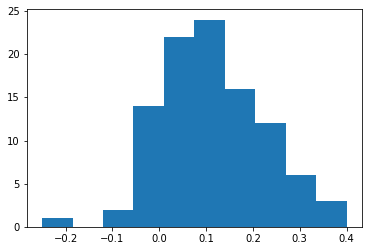

In [9]:
ls = []
for run in range(100):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]
plt.hist(ls) 

### Counterfactual fairness

In [10]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

#### Natural Direct Effects

In [51]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'race': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(0)})() for _ in range(1000)]

In [52]:
e1_avg = sum(e1_samples) / len(e1_samples)
e2_avg = sum(e2_samples) / len(e2_samples)

In [53]:
e1_avg - e2_avg

tensor(-0.1000)

#### Natural Indirect Effects

In [55]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'c_charge_degree': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [56]:
e1_avg = sum(e1_samples) / len(e1_samples)
e2_avg = sum(e2_samples) / len(e2_samples)

In [57]:
e1_avg - e2_avg

tensor(-0.0810)

#### Inference

(array([ 4.,  4., 18., 16., 13., 24., 14.,  5.,  1.,  1.]),
 array([0.4  , 0.424, 0.448, 0.472, 0.496, 0.52 , 0.544, 0.568, 0.592,
        0.616, 0.64 ]),
 <a list of 10 Patch objects>)

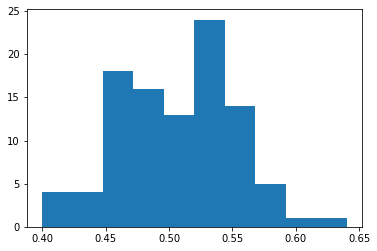

In [11]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in range(100):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]
plt.hist(ls) 